In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Assemble Stan Fits

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define I/O parameters.
files = dict(
    study01 = os.path.join('stan_results', 'study01', '2pl_full_summary.tsv'),
    study02 = os.path.join('stan_results', 'study02', '2pl_full_summary.tsv'),
    study03 = os.path.join('stan_results', 'study03', '2pl_summary.tsv'),
)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
data = []

## Iteratively load summary files.
for k, v in files.items():

    ## Load DataFrame.
    df = read_csv(v, sep='\t')
    
    ## Update column names.
    df.columns = [col.lower() for col in df.columns]
    df = df.rename(columns={'unnamed: 0':'param', 'name':'param', 'stddev':'sd'})
    df = df[['param','mean','sd','50%']]
    
    ## Insert metadata.
    df.insert(0, 'study', k)
    
    ## Append.
    data.append(df)
    
## Concatenate DataFrames.
data = concat(data)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Format data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Restrict to parameters of interest.
ix = np.logical_or(data.param.str.find('beta')==0, data.param.str.find('alpha')==0)
data = data[ix].reset_index(drop=True)

## Define item identities.
data.insert(1, 'item', [int(s[:-1].split('[')[-1]) for s in data.param])
s3 = np.unique(read_csv(os.path.join('data','study03','data.csv')).stimulus)
data.loc[data.study=="study03",'item'] = s3[data.loc[data.study=="study03",'item']-1]
data['param'] = [s.split('[')[0] for s in data.param]

## Define item dimension.
df = read_csv(os.path.join('data','dimensionality.csv'))
df = df.rename(columns={'Item':'item','Dimensionality Score':'dimension'})
data = data.merge(df)

## Sort data.
data = data.sort_values(['study','item','param']).reset_index(drop=True)

## Section 2: Parameter Consistency

#### 2.1 Item difficulties

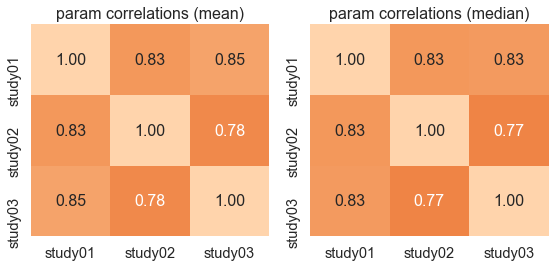

In [3]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(8,4))

## Define pivot table.
pivot = data.query('param=="beta"').pivot_table(['mean','50%'],'item','study')

## Plot correlations (mean).
sns.heatmap(pivot['mean'].corr(method='spearman'), vmin=-1, vmax=1, center=0, 
            cbar=False, annot=True, fmt='0.2f', ax=axes[0])
axes[0].set(xlabel='', ylabel='', title='param correlations (mean)')

## Plot correlations (median).
sns.heatmap(pivot['50%'].corr(method='spearman'), vmin=-1, vmax=1, center=0, 
            cbar=False, annot=True, fmt='0.2f', ax=axes[1])
axes[1].set(xlabel='', ylabel='', title='param correlations (median)')

plt.tight_layout()

#### 2.2 Item discriminations

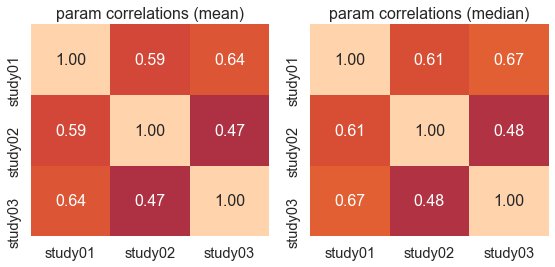

In [4]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(8,4))

## Define pivot table.
pivot = data.query('param=="alpha"').pivot_table(['mean','50%'],'item','study')

## Plot correlations (mean).
sns.heatmap(pivot['mean'].corr(method='spearman'), vmin=-1, vmax=1, center=0, 
            cbar=False, annot=True, fmt='0.2f', ax=axes[0])
axes[0].set(xlabel='', ylabel='', title='param correlations (mean)')

## Plot correlations (median).
sns.heatmap(pivot['50%'].corr(method='spearman'), vmin=-1, vmax=1, center=0, 
            cbar=False, annot=True, fmt='0.2f', ax=axes[1])
axes[1].set(xlabel='', ylabel='', title='param correlations (median)')

plt.tight_layout()

## Section 3: Parameter Values

#### 3.1 Item difficulies

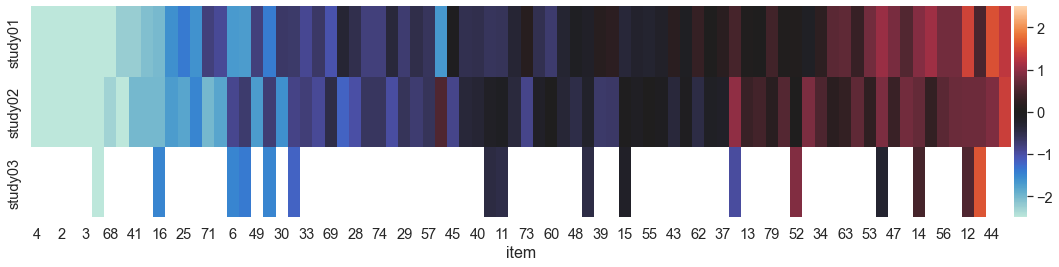

In [5]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(15,4))
divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("right", size="1.25%", pad=0.05)

## Construct pivot table. Sort by difficulty.
pivot = data.query('param=="beta"').pivot_table('mean','study','item')
pivot = pivot[pivot.mean().sort_values().index]

## Plot difficulties.
sns.heatmap(pivot, center=0, vmin=-2.5, vmax=2.5, ax=ax, cbar_ax=cbar_ax)

## Add detail.
ax.set(ylabel='')
ax.set_yticklabels(['study01','study02','study03'], va='center')

plt.tight_layout()

#### 3.2 Item discriminations

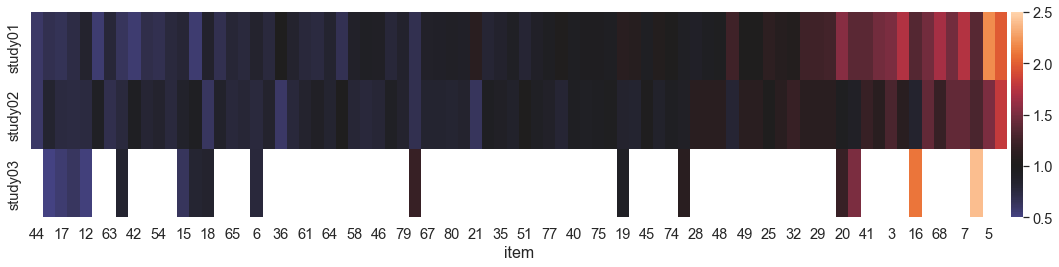

In [6]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(15,4))
divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("right", size="1.25%", pad=0.05)

## Construct pivot table. Sort by difficulty.
pivot = data.query('param=="alpha"').pivot_table('mean','study','item')
pivot = pivot[pivot.mean().sort_values().index]

## Plot difficulties.
sns.heatmap(pivot, center=1, vmin=0.5, vmax=2.5, ax=ax, cbar_ax=cbar_ax)

## Add detail.
ax.set(ylabel='')
ax.set_yticklabels(['study01','study02','study03'], va='center')

plt.tight_layout()

#### 3.3 Parameter conjunction

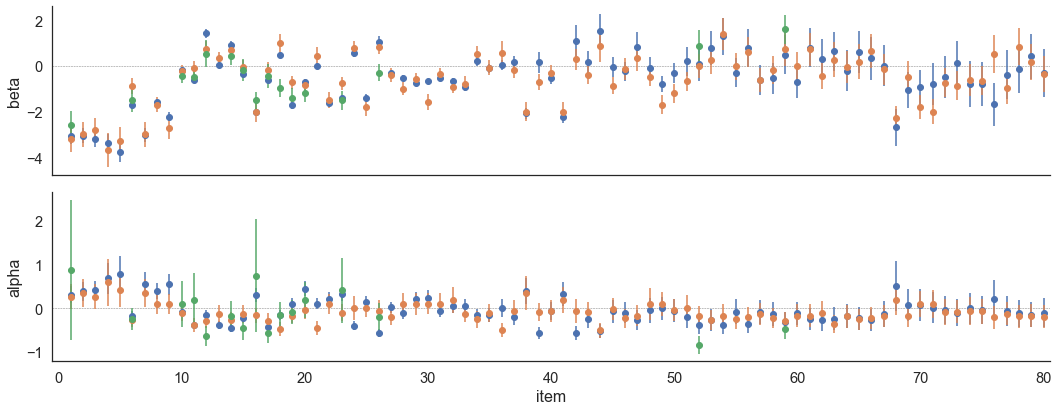

In [7]:
## Initialize canvas.
fig, axes = plt.subplots(2,1,figsize=(15,6),sharex=True)
palette = {'study01':'#4c72b0', 'study02':'#dd8452', 'study03':'#55a868'}

## Iteratively plot parameters.
for i, (ax, param) in enumerate(zip(axes, ['beta','alpha'])):
    
    ## Restrict to parameter of interest.
    df = data.query(f'param == "{param}"').copy()
    if param == 'alpha': df['mean'] = np.log(df['mean'])
    
    ## Plot estimates.
    for _, row in df.iterrows():
        ax.errorbar(row['item'], row['mean'], yerr=row['sd'], fmt='o', color=palette[row['study']])
        
    ## Add detail.
    ax.axhline(0, color='0.5', lw=0.5, linestyle='--', zorder=-1)
    ax.set(xlim=(-0.5,80.5), ylabel=param)
    if i: ax.set(xlabel='item')
    
sns.despine()
plt.tight_layout()

#### 3.4 Parameter correlations

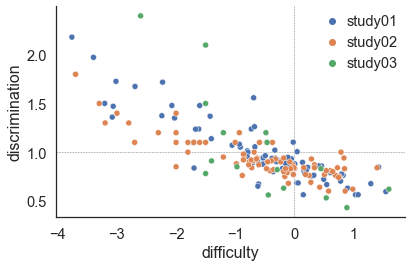

In [8]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Construct pivot table.
pivot = data.pivot_table('mean',['study','item'],'param').reset_index()

## Plot item correlations.
sns.scatterplot(x='beta', y='alpha', hue='study', data=pivot, ax=ax)
ax.axhline(1, color='0.5', lw=0.5, linestyle='--', zorder=-1)
ax.axvline(0, color='0.5', lw=0.5, linestyle='--', zorder=-1)

## Add detail
ax.legend(loc=1, frameon=False, borderpad=0, handletextpad=0)
ax.set(xlabel='difficulty', ylabel='discrimination')

sns.despine()
plt.tight_layout()

## Section 4: Construct Validity

#### 4.1 Parameters by dimensionality

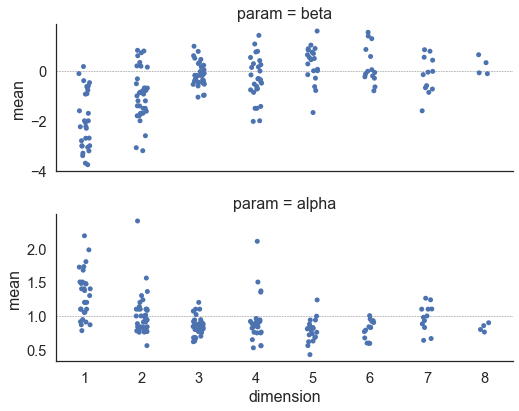

In [9]:
## Initialize canvas.
g = sns.FacetGrid(data, row='param', row_order=['beta','alpha'], sharey=False, aspect=2.5)

## Plot parameters.
g.map(sns.stripplot, 'dimension', 'mean', order=np.arange(8)+1)

## Add detail.
g.axes[0,0].axhline(0, color='0.5', lw=0.5, linestyle='--', zorder=-1);
g.axes[1,0].axhline(1, color='0.5', lw=0.5, linestyle='--', zorder=-1);